In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.204



In [8]:
dc = DC()
dc.idn()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



In [3]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



# Set all devises to defoult values

In [9]:
# Anapico 
anapico.off(1)

#dc 
dc.set_volt(0)

In [10]:
anapico.on(1)

In [11]:
# boundaries

freq_pump_max = 12 #GHz
freq_pump_min = 10 #GHz

power_pump_max = -6 #dBm
power_pump_min = -26 #dBm

dc_max = 3 # V
dc_min = 1 # V

# Just scan over all range

In [12]:
number_of_freq_steps = 5
number_of_power_steps = 5
number_of_dc_steps = 5 

freq = np.linspace(freq_pump_min, freq_pump_max, number_of_freq_steps)
powers = np.linspace(power_pump_min, power_pump_max, number_of_power_steps)
dcs = np.linspace(dc_min, dc_max, number_of_dc_steps)

reference_freq = 5.8

Sweep time: 1.7957113281666668 m


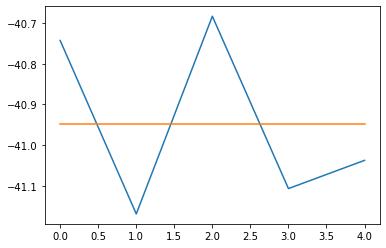

In [19]:
vna.set_cw_freq(reference_freq)
vna.set_power(-10)
vna.set_nop(5)
vna.set_band(1000)
one_round_time = vna.ask_sweep_time()/60

print('Sweep time: {} m'.format(one_round_time))

mag, pha = vna.get_data()
reference_mag_level = np.mean(mag)
plt.plot(mag)
plt.plot(np.ones(len(mag))*reference_mag_level)

# Gradient Descent

In [14]:
def get_gain(freq_curr, powers_curr, dc_curr):
    anapico.set_freq(1, freq_curr)
    anapico.set_power(1, powers_curr)
    dc.set_volt(dc_curr)
    mag, pha = vna.get_data()
    gain = np.mean(mag) - reference_mag_level
    return gain

def wrapped_gain(g): 
    freq_curr = g[0]
    powers_curr = g[1]
    dc_curr = g[2]
    print(g)
    if freq_curr<=freq_pump_max and freq_curr>=freq_pump_min:
        if powers_curr>=power_pump_min and powers_curr<=power_pump_max: 
            if dc_curr<=dc_max and dc_curr>=dc_min:
                gain = get_gain(freq_curr, powers_curr, dc_curr)
                print(gain)
                return -gain
    
    return 100

In [ ]:
x0 = np.array([11.252, -7, 2.4])
anapico.on(1)

start_time = datetime.now()
print('Start time', start_time)
res = minimize(wrapped_gain, x0, method='nelder-mead',
               options={'xatol': 1e-6,})
print(res.x)


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Start time 2023-11-30 19:02:18.661798
[11.252 -7.     2.4  ]
-0.9241298662226072
[11.8146 -7.      2.4   ]
-0.8932685889527647
[11.252 -7.35   2.4  ]
-0.6887538047348656
[11.252 -7.     2.52 ]
